In [3]:
#Libraries
import os
import numpy as np
from skimage import io
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import resize
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from scipy.interpolate import interp1d


In [4]:
def extract_glcms(image):
    # Calculate GLCM as before 
    distances = [1]#,2,3,4,5]  #distances for the GLCM
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]    #angles for the GLCM
    levels = 256

    glcm = graycomatrix(image, distances, angles, levels=levels, symmetric=True, normed=True)  #calculate the co-occurance matrix
    glcm_features = np.concatenate([graycoprops(glcm, 'contrast').ravel(),  #calculate the features
                                     graycoprops(glcm, 'dissimilarity').ravel(),
                                     graycoprops(glcm, 'homogeneity').ravel(),
                                     graycoprops(glcm, 'energy').ravel(),
                                     graycoprops(glcm, 'correlation').ravel(),
                                     graycoprops(glcm, 'ASM').ravel()])
    return glcm_features

In [5]:
def separate_and_extract_glcms(path):
    image = io.imread(path)

    #separate between rgb channels
    red = image[:, :, 0]
    green = image[:, :, 1]
    blue= image[:, :, 2]

    #extract features
    glcm_features_r = extract_glcms(red)
    glcm_features_g = extract_glcms(green)
    glcm_features_b = extract_glcms(blue)

    return glcm_features_r, glcm_features_g, glcm_features_b

In [6]:
path = 'traintest/'

glcm_features_r_list = []
glcm_features_g_list = []
glcm_features_b_list = []

for class_name in os.listdir(path):
    #print(class_name)
    class_path = os.path.join(path, class_name)
    print(path)
    print(class_path)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                glcm_features_r, glcm_features_g, glcm_features_b = separate_and_extract_glcms(image_path)
                glcm_features_r_list.append(glcm_features_r)
                glcm_features_g_list.append(glcm_features_g)
                glcm_features_b_list.append(glcm_features_b)

glcm_features_r_array = np.array(glcm_features_r_list)
glcm_features_g_array = np.array(glcm_features_g_list)
glcm_features_b_array = np.array(glcm_features_b_list)

print('GLCM features for R ch were:', glcm_features_r_array.shape)
print('GLCM features for G ch were:', glcm_features_g_array.shape)
print('GLCM features for B ch were:', glcm_features_b_array.shape)


traintest/
traintest/0 - adenoma
traintest/
traintest/1 - hyperplasic
GLCM features for R ch were: (115, 24)
GLCM features for G ch were: (115, 24)
GLCM features for B ch were: (115, 24)


In [29]:
def extract_deep_features(image):
    preprocessed_image = preprocess_input(image)
    deep_features = model.predict(np.expand_dims(preprocessed_image, axis=0))
    #selected_features = [deep_features[0,:,:,i] for i in layers]
    return deep_features

In [11]:
class_folder_path = 'traintest/'

classes = os.listdir(class_folder_path)

deep_features_list = []
labels_list = []

#pretrained model 
model = DenseNet201(weights='imagenet', include_top=True)
last_dense_block = model.get_layer('conv5_block32_concat')

#new model made from the pretrained 
deep_features_model = tf.keras.Model(inputs=model.input, outputs=last_dense_block.output)

for i, class_name in enumerate(classes):
    class_path = os.path.join(class_folder_path, class_name)
    images = os.listdir(class_path)

    for image_name in images:
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        resized_image = cv2.resize(image, (224, 224))
        deep_features = extract_deep_features(resized_image)
        deep_features_list.append(deep_features)
        labels_list.append(class_name)

deep_features_array = np.array(deep_features_list)
flattened_deep_features = deep_features_array.reshape(deep_features_array.shape[0], -1)
labels_array = np.array(labels_list)

print('Deep Features shape:', flattened_deep_features.shape)
print('Labels shape:', labels_array.shape)


1/1 [==============================] - 0s 318ms/step
Deep Features shape: (115, 94080)
Labels shape: (115,)


In [30]:
##OTRO USO - wrong try, do not use
#using pretrained DenseNet201 model for the custom made model
model = DenseNet201(weights='imagenet', include_top=False)
#layers = [4, 6, 14, 19, 22, 23]

for i, class_name in enumerate(classes):
    class_path = os.path.join(class_folder_path, class_name)
    images = os.listdir(class_path)

    for image_name in images:
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #plt.imshow(image)
        #plt.show()

        resized_image = cv2.resize(image, (224, 224))   #resize pic
        deep_features = extract_deep_features(resized_image)    #extract features from custom model
        print(deep_features.shape)
        deep_features_list.append(deep_features)    #save deep features in a list
        #print(deep_features_list)
        labels_list.append(class_name)  #save labels for pictures in a list

deep_features_array = np.concatenate(deep_features_list)
flattened_deep_features = deep_features_array.reshape(deep_features_array.shape[0], -1)
labels_array = np.array(labels_list)

print('deep Features shape:', deep_features_array.shape)
print('labels shape:', labels_array.shape)

Exception ignored in: <function UniquePtr.__del__ at 0x000001A968A1E9E0>
Traceback (most recent call last):
  File "C:\Users\juana\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\framework\c_api_util.py", line 74, in __del__
    self.deleter(obj)
KeyboardInterrupt: 


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'tests/1 - hyperplasic\\0 - adenoma'

combino esto (115, 72)
con esto (115, 94080)
(115,)
(115, 94152)


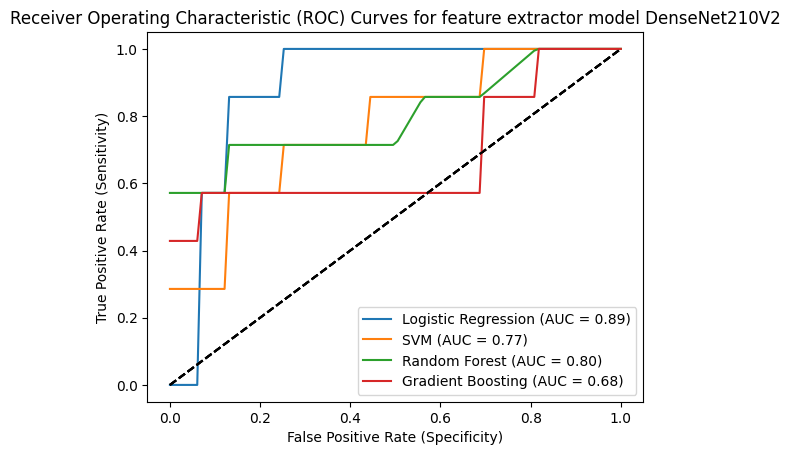

accuracies [0.8260869565217391, 0.7391304347826086, 0.8695652173913043, 0.6086956521739131]
TN [14, 13, 16, 10]
FP [2, 3, 0, 6]
FN [2, 3, 3, 3]
TP [5, 4, 4, 4]
precision [0.7142857142857143, 0.5714285714285714, 1.0, 0.4]
recall [0.7142857142857143, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714]
f1 acore [0.7142857142857143, 0.5714285714285714, 0.7272727272727273, 0.47058823529411764]
specificity [0.875, 0.8125, 1.0, 0.625]
sensitiviy [0.7142857142857143, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714]


In [27]:
combined_glcms = np.concatenate((glcm_features_r_array, glcm_features_g_array, glcm_features_b_array), axis=1)
print("combino esto", combined_glcms.shape)
print("con esto", flattened_deep_features.shape)
print(labels_array.shape)
combined_features = np.concatenate((combined_glcms, flattened_deep_features), axis=1)
print(combined_features.shape)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels_array, test_size=0.2, random_state=42)

# Transform labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create classifiers
lr_classifier = classifier = LogisticRegression(max_iter=1000)

svm_classifier = svm.SVC(probability=True)
rf_classifier = RandomForestClassifier()
gb_classifier = GradientBoostingClassifier()

classifiers = [lr_classifier, svm_classifier, rf_classifier, gb_classifier]
classifier_labels = ['Logistic Regression', 'SVM', 'Random Forest', 'Gradient Boosting']
accuracy_list = []
TN_list = []
FN_list = []
TP_list = []
FP_list = []
precision_list = []
recall_list = []
f1_list = []
specificity_list = []
plt.figure()

for classifier, label in zip(classifiers, classifier_labels):
    classifier.fit(X_train, y_train_encoded)
    y_scores = classifier.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test_encoded, y_scores)
    interp_fpr = np.linspace(0, 1, 100)
    interp_tpr = interp1d(fpr, tpr)(interp_fpr)
    auc_score = auc(interp_fpr, interp_tpr)
    y_pred_proba = classifier.predict_proba(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    label_encoder = LabelEncoder()
    y_true = label_encoder.fit_transform(y_test)

    accuracy = accuracy_score(y_true, y_pred)   #calculate accuracy
    accuracy_list.append(accuracy)
    cm = confusion_matrix(y_true, y_pred)       #calculate confusion matrix 
    TN = cm[0, 0]  # True negatives
    FP = cm[0, 1]  # False positives
    FN = cm[1, 0]  # False negatives
    TP = cm[1, 1]  # True positives
    TN_list.append(TN)
    FP_list.append(FP)
    FN_list.append(FN)
    TP_list.append(TP)

    #PRECISION RECALL AND F1
    precision = precision_score(y_true, y_pred)
    precision_list.append(precision)
    recall = recall_score(y_true, y_pred)
    recall_list.append(recall)
    f1 = f1_score(y_true, y_pred)
    f1_list.append(f1)

    #specificity and sensitivity
    true_negative = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    false_positive = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    specificity = true_negative / (true_negative + false_positive)
    specificity_list.append(specificity)
    sensitivity = recall

    #plot roc
    plt.plot(interp_fpr, interp_tpr, label=f'{label} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
    plt.xlabel('False Positive Rate (Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curves for feature extractor model DenseNet210V2')
    plt.legend(loc='lower right')
plt.show()

print('accuracies', accuracy_list)    #show accuracy

print('TN', TN_list)  #show confusion matrix values
print('FP', FP_list)
print('FN', FN_list)
print('TP', TP_list)

print('precision', precision_list)
print('recall', recall_list)
print('f1 acore', f1_list)
print('specificity', specificity_list)
print('sensitiviy', recall_list)

In [28]:
test_path = "tests/"

glcm_features_r_list_test = []
glcm_features_g_list_test = []
glcm_features_b_list_test = []

class_folders = os.listdir(test_path)

for class_folder in class_folders:
    class_folder_path = os.path.join(test_path, class_folder)
    if not os.path.isdir(class_folder_path):
        continue
    
    for img in os.listdir(class_folder_path):
        img_path = os.path.join(class_folder_path, img)
        #img = cv2.imread(img_path)
        #cv2.imshow('Image', img)
        #plt.imshow(img, cmap='gray')
        #plt.show()
        print(img_path)
        glcm_features_r_test, glcm_features_g_test, glcm_features_b_test = separate_and_extract_glcms(img_path)
        glcm_features_r_list_test.append(glcm_features_r_test)
        glcm_features_g_list_test.append(glcm_features_g_test)
        glcm_features_b_list_test.append(glcm_features_b_test)

# Convert the lists to NumPy arrays
glcm_features_r_array_test = np.array(glcm_features_r_list_test)
glcm_features_g_array_test = np.array(glcm_features_g_list_test)
glcm_features_b_array_test = np.array(glcm_features_b_list_test)

print('GLCM features for R channel:', glcm_features_r_array_test.shape)
print('GLCM features for G channel:', glcm_features_g_array_test.shape)
print('GLCM features for B channel:', glcm_features_b_array_test.shape)

tests/0 - adenoma\1.jpg
tests/0 - adenoma\17.jpg
tests/0 - adenoma\24.jpg
tests/0 - adenoma\26.jpg
tests/0 - adenoma\29.jpg
tests/0 - adenoma\37.jpg
tests/0 - adenoma\41.jpg
tests/0 - adenoma\45.jpg
tests/0 - adenoma\49.jpg
tests/0 - adenoma\55.jpg
tests/0 - adenoma\56.jpg
tests/0 - adenoma\62.jpg
tests/0 - adenoma\a (5).jpg
tests/0 - adenoma\a (9).jpg
tests/1 - hyperplasic\12.jpg
tests/1 - hyperplasic\17.jpg
tests/1 - hyperplasic\2.jpg
tests/1 - hyperplasic\20.jpg
tests/1 - hyperplasic\22.jpg
tests/1 - hyperplasic\6.jpg
tests/1 - hyperplasic\h (2).jpg
tests/1 - hyperplasic\h (3).jpg
GLCM features for R channel: (22, 24)
GLCM features for G channel: (22, 24)
GLCM features for B channel: (22, 24)


In [8]:


deep_features_list_test = []
labels_list_test = []
classes = os.listdir(test_path)

for i, class_name in enumerate(classes):
    class_path = os.path.join(test_path, class_name)
    images = os.listdir(class_path)

    for image_name in images:
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        resized_image_test = cv2.resize(image, (224, 224))
        deep_features_test = extract_deep_features(resized_image_test)
        print(deep_features_test.shape)
        deep_features_list_test.append(deep_features_test)
        #print(deep_features_list)
        labels_list_test.append(class_name)
        print(labels_list_test)

deep_features_array_test = np.concatenate(deep_features_list_test)
flattened_deep_features_test = deep_features_array_test.reshape(deep_features_array_test.shape[0], -1)
print(flattened_deep_features_test.shape)
print(labels_list_test)


1/1 [==============================] - 0s 377ms/step
(1, 7, 7, 1920)
['0 - adenoma']
1/1 [==============================] - 0s 210ms/step
(1, 7, 7, 1920)
['0 - adenoma', '0 - adenoma']
1/1 [==============================] - 0s 207ms/step
(1, 7, 7, 1920)
['0 - adenoma', '0 - adenoma', '0 - adenoma']
1/1 [==============================] - 0s 200ms/step
(1, 7, 7, 1920)
['0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma']
1/1 [==============================] - 0s 210ms/step
(1, 7, 7, 1920)
['0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma']
1/1 [==============================] - 0s 211ms/step
(1, 7, 7, 1920)
['0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma']
1/1 [==============================] - 0s 205ms/step
(1, 7, 7, 1920)
['0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma']
1/1 [==============================] - 0s 202ms/step
(1, 7, 7, 1920)
['0 - adenoma', '0 - 

In [9]:
combined_glcms_test = np.concatenate((glcm_features_r_array_test, glcm_features_g_array_test, glcm_features_b_array_test), axis=1)
print(combined_glcms_test.shape)
#combined_glcms = np.repeat(combined_glcms, 7, axis=0)
print(combined_glcms_test.shape)
print(flattened_deep_features_test.shape)
flattened_deep_features_test = flattened_deep_features_test.reshape(flattened_deep_features_test.shape[0], -1)
print(flattened_deep_features_test.shape)
combined_features_test = np.concatenate((combined_glcms_test, flattened_deep_features_test), axis=1)
print(combined_features_test.shape)

(26, 72)
(26, 72)
(26, 94080)
(26, 94080)
(26, 94152)


In [10]:
pred_test = classifier.predict(combined_features_test)
labels_array_test = np.array(labels_list_test)
print(pred_test.shape)
print(labels_array_test.shape)

(26,)
(26,)


In [14]:
TA = 0
FA = 0
TH = 0
FH = 0
        
for i, prediction in enumerate(pred_test):
    print("The prediction for the picture is", prediction)
    print("The ground truth was", labels_list_test[i])
    if prediction == labels_list_test[i]:
        if prediction == "0 - adenoma":
            TA = 1+TA
        else:
            if prediction =="1 - hyperplasic":
                TH = 1+TH
    else:
        if prediction == "0 - adenoma":
            FA = 1+FA
        else:
            if prediction =="1 - hyperplasic":
                FH = 1+FH 


print("The TA  are ", TA)
print("The FA are ", FA)
print("The TH  are ", TH)
print("The FH are ", FH)

TPR = 0
TPR = TA/(TA + FH)
FPR = 0
FPR = FA/(FA+TH)
acc = 0
acc=(TA+TH)/(TA+FA+FH+TH)
print("The accuracy is ", acc)
sensitivity = TA/(TA+FH)
print(sensitivity, "sensitivity")
specificity = TH/(TH+FA)
print(specificity, "specificity")
print(TPR)
print(FPR)

The prediction for the picture is 0 - adenoma
The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma
The ground truth was 0 - adenoma
The prediction for the picture is 1 - hyperplasic
The ground truth was 0 - adenoma
The prediction for the picture is 1 - hyperplasic
The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma
The ground truth was 0 - adenoma
The prediction for the picture is 1 - hyperplasic
The ground truth was 0 - adenoma
The prediction for the picture is 1 - hyperplasic
The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma
The ground truth was 0 - adenoma
The prediction for the picture is 1 - hyperplasic
The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma
The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma
The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma
The ground truth was 0 - adenoma
The prediction for the picture i

['0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '1 - hyperplasic', '1 - hyperplasic', '1 - hyperplasic', '1 - hyperplasic', '1 - hyperplasic', '1 - hyperplasic', '1 - hyperplasic', '1 - hyperplasic', '1 - hyperplasic', '1 - hyperplasic', '1 - hyperplasic']
['0 - adenoma' '0 - adenoma' '1 - hyperplasic' '1 - hyperplasic'
 '0 - adenoma' '1 - hyperplasic' '1 - hyperplasic' '0 - adenoma'
 '1 - hyperplasic' '0 - adenoma' '0 - adenoma' '0 - adenoma' '0 - adenoma'
 '0 - adenoma' '0 - adenoma' '1 - hyperplasic' '0 - adenoma'
 '1 - hyperplasic' '1 - hyperplasic' '1 - hyperplasic' '1 - hyperplasic'
 '1 - hyperplasic' '1 - hyperplasic' '1 - hyperplasic' '1 - hyperplasic'
 '1 - hyperplasic']
[[10  5]
 [ 1 10]]


<Axes: >

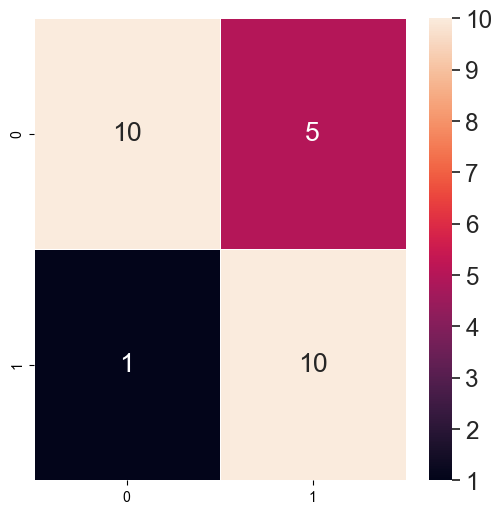

In [24]:


print(labels_list_test)
print(pred_test)
cm = confusion_matrix(labels_list_test, pred_test)
print(cm)

fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)